In [121]:
## Necessary packages
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import warnings
warnings.filterwarnings("ignore")

# 1. TimeGAN model
from timegan import timegan
# 2. Data loading
from data_loading import real_data_loading, sine_data_generation
# 3. Metrics
from metrics.discriminative_metrics import discriminative_score_metrics
from metrics.predictive_metrics import predictive_score_metrics
from metrics.visualization_metrics import visualization
import pandas as pd
from tqdm import tqdm

In [122]:
def get_intervals(data):
    index=data['index']
    last_value=index[0]-1
    last_index=0
    intervals=[]
    for i in range(data.shape[0]):
        if last_value!=index[i]-1:
            intervals.append([last_index,i])
            last_value=index[i]
            last_index=i
        last_value=index[i]
    intervals.append([last_index, i])
    return intervals

In [123]:
def interpolation(data):
    max_len=24
    l=len(data)
    to_fill=max_len-l
    if to_fill!=0:
        interval=max_len//to_fill
        for j in range(to_fill):
            idx=(interval+1)*j+interval
            data.insert(min(idx,len(data)-1),float('nan'))
    data=pd.Series(data).interpolate(method='polynomial', order=2)
    return data

In [124]:
def MinMaxScaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    norm_data = numerator / (denominator + 1e-7)
    return norm_data

In [125]:
def minmax_normlization(data):
    normalized_data=(data-data.min())/(data.max()-data.min())
    return normalized_data

In [226]:
def get_data_of_same_length(data,seq_len):
    data_processed=[]
    intervals=get_intervals(data)
    temp_data=[]
    data.drop(columns=['index'])
    for interval in intervals:
#         print(interval)
        data_seg=data.iloc[interval[0]:interval[1],:]
        for i in range(0, len(data_seg) - seq_len):
            _x = data_seg.iloc[i:i + seq_len,:]
            temp_data.append(_x)
    return temp_data

# Run through

In [33]:
def dataset_prepareation(path):
    data=pd.read_csv(path).reset_index()
    tics=data['tic'].unique()
    features=[ 'open', 'high', 'low', 'close', 'adjcp','zopen', 'zhigh', 'zlow', 'zadjcp', 'zclose', 'zd_5', 'zd_10',
       'zd_15', 'zd_20', 'zd_25', 'zd_30', 'pct_return', 'adjcp_filtered',
       'pct_return_filtered','volume']
    ret=[]
    for col in data.columns:
        if col in features:
            ret.append(col)
    features=ret
    for tic in tics:
        data_by_tic=data.loc[data['tic']==tic,features].astype(float)
        norm_data_by_tic=MinMaxScaler(data_by_tic)
        data.loc[data['tic']==tic,features]=norm_data_by_tic
    stock_group_num=len(data['stock_type'].unique())
    regime_num=len(data['label'].unique())
    for tic in tics:
        for j in range(regime_num):
            data_seg=data.loc[(data['tic']==tic) & (data['label']==j),['index','open','high','low','close','adjcp','volume']]
    #         data_dict[(i,j)]=data_seg
            data_seg.to_csv('./data/data_seg_'+tic+'_'+str(j)+'.csv')

## Data Loading

Load original dataset and preprocess the loaded data.

- data_name: stock, energy, or sine
- seq_len: sequence length of the time-series data

In [94]:
data=pd.read_csv('/home/hcxia/TradeMaster_dev/TradeMaster/data_synthesis/TimeGAN/GOOG_labeled_3_24.csv').reset_index()

In [10]:
data=pd.read_csv("./DJI_all_labeled_3_24.csv").reset_index()

In [34]:
dataset_prepareation("./DJI_all_labeled_3_24.csv")

In [35]:
dataset_prepareation('/home/hcxia/TradeMaster_dev/TradeMaster/data_synthesis/TimeGAN/GOOG_labeled_3_24.csv')

# Make data dict

In [127]:
def prepare_data_for_trainning(path):
    data=pd.read_csv(path).drop('index', axis=1)
    data=data.reset_index().rename(columns={data.index.name:'index'})
#     display(data.head())
    data=get_data_of_same_length(data,24)
#     display(len(data))
    data=[d.loc[:,['open','high','low','close','adjcp','volume']].to_numpy() for d in data]
    return data

### GOOG data

In [128]:
GOOG_data={}
for i in range(3):
    GOOG_data['data_seg_GOOG_'+str(i)]=prepare_data_for_trainning('./data/data_seg_GOOG_'+str(i)+'.csv')
    print(i,len(GOOG_data['data_seg_GOOG_'+str(i)]))

0 673
1 1591
2 1529


### Single stock data

In [129]:
data=pd.read_csv("./DJI_all_labeled_3_24.csv").reset_index()
tics=data['tic'].unique()
data_dict_tic={}
for tic in tics:
    data_dict_tic[tic]={}
    for i in range(3):
        data_dict_tic[tic]['data_seg_'+str(tic)+'_'+str(i)]=prepare_data_for_trainning('./data/data_seg_'+str(tic)+'_'+str(i)+'.csv')
        print(tic,i,len(data_dict_tic[tic]['data_seg_'+str(tic)+'_'+str(i)]))

AAPL 0 1147
AAPL 1 1982
AAPL 2 2583
CSCO 0 1208
CSCO 1 2707
CSCO 2 1797
TRV 0 867
TRV 1 3239
TRV 2 1606
CAT 0 1319
CAT 1 2117
CAT 2 2276
UNH 0 647
UNH 1 2939
UNH 2 2126
BA 0 1332
BA 1 2362
BA 2 2018
VZ 0 886
VZ 1 3713
VZ 2 1113
CVX 0 840
CVX 1 3201
CVX 2 1671
PG 0 460
PG 1 4131
PG 2 1121
HD 0 1094
HD 1 2645
HD 2 1973
GS 0 1140
GS 1 2737
GS 2 1835
MSFT 0 956
MSFT 1 3130
MSFT 2 1626
DIS 0 954
DIS 1 3054
DIS 2 1704
NKE 0 967
NKE 1 2592
NKE 2 2153
HON 0 904
HON 1 3137
HON 2 1671
MMM 0 813
MMM 1 3439
MMM 2 1460
INTC 0 1363
INTC 1 2440
INTC 2 1909
KO 0 394
KO 1 4438
KO 2 880
JNJ 0 290
JNJ 1 4546
JNJ 2 876
JPM 0 1099
JPM 1 2731
JPM 2 1882
IBM 0 940
IBM 1 3272
IBM 2 1500
MCD 0 714
MCD 1 3668
MCD 2 1330
WBA 0 948
WBA 1 3243
WBA 2 1521
AXP 0 1003
AXP 1 3140
AXP 2 1569
MRK 0 1015
MRK 1 3193
MRK 2 1504
WMT 0 695
WMT 1 3919
WMT 2 1098
AMGN 0 1051
AMGN 1 3073
AMGN 2 1588


### Stock group data

In [130]:
data=pd.read_csv("./DJI_all_labeled_3_24.csv").reset_index()
# display(data.columns)
tic_group_pair=data.loc[:,['tic','stock_type']]
tic_group_pair=tic_group_pair.groupby(['tic','stock_type']).size().reset_index(name='Freq')
stock_group_num=len(data['stock_type'].unique())
tic_in_group={}
for group in range(stock_group_num):
#     if group not in tic_in_group：
#         tic_in_group[group]=[]
    tic_in_group[group]=list(tic_group_pair.loc[tic_group_pair['stock_type']==group,:]['tic'].unique())

In [131]:
print(tic_in_group)

{0: ['BA', 'HD', 'MSFT', 'UNH'], 1: ['AXP', 'DIS', 'JPM', 'PG', 'WMT'], 2: ['AAPL', 'NKE'], 3: ['AMGN', 'CAT', 'CVX', 'HON', 'IBM', 'JNJ', 'MCD', 'MMM', 'TRV'], 4: ['CSCO', 'INTC', 'KO', 'MRK', 'VZ', 'WBA'], 5: ['GS']}


In [132]:
data=pd.read_csv("./DJI_all_labeled_3_24.csv").reset_index()
stock_group_num=len(data['stock_type'].unique())
data_dict_group={}
for group in range(stock_group_num):
    data_dict_group[group]={}
    for i in range(3):
        if 'data_seg_'+str(group)+'_'+str(i) not in data_dict_group[group]:
            data_dict_group[group]['data_seg_'+str(group)+'_'+str(i)]=[]
        for tic in tic_in_group[group]:
            data_dict_group[group]['data_seg_'+str(group)+'_'+str(i)].extend(data_dict_tic[tic]['data_seg_'+str(tic)+'_'+str(i)])
        print(group,i,len(data_dict_group[group]['data_seg_'+str(group)+'_'+str(i)]))

0 0 4029
0 1 11076
0 2 7743
1 0 4211
1 1 16975
1 2 7374
2 0 2114
2 1 4574
2 2 4736
3 0 7738
3 1 29692
3 2 13978
4 0 5814
4 1 19734
4 2 8724
5 0 1140
5 1 2737
5 2 1835


### All dji stock data

In [133]:
data=pd.read_csv("./DJI_all_labeled_3_24.csv").reset_index()
tics=data['tic'].unique()
data_all={}
for i in range(3):
    if 'data_seg_'+'all'+'_'+str(i) not in data_all:
        data_all['data_seg_'+'all'+'_'+str(i)]=[]
    for tic in tics:
        data_all['data_seg_'+'all'+'_'+str(i)].extend(data_dict_tic[tic]['data_seg_'+str(tic)+'_'+str(i)])
    print(i,len(data_all['data_seg_'+'all'+'_'+str(i)]))

0 25046
1 84788
2 44390


# data set:

- GOOG_data
- data_dict_tic (dict of dict by tic)
- data_dict_group (dict of dict by group num)
- data_all

In [213]:
print(GOOG_data.keys())
print(data_dict_tic.keys())
print(data_dict_group.keys())
print(data_all.keys())

dict_keys(['data_seg_GOOG_0', 'data_seg_GOOG_1', 'data_seg_GOOG_2'])
dict_keys(['AAPL', 'CSCO', 'TRV', 'CAT', 'UNH', 'BA', 'VZ', 'CVX', 'PG', 'HD', 'GS', 'MSFT', 'DIS', 'NKE', 'HON', 'MMM', 'INTC', 'KO', 'JNJ', 'JPM', 'IBM', 'MCD', 'WBA', 'AXP', 'MRK', 'WMT', 'AMGN'])
dict_keys([0, 1, 2, 3, 4, 5])
dict_keys(['data_seg_all_0', 'data_seg_all_1', 'data_seg_all_2'])


# Pre-train Static learning classification discriminator

In [1]:
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sktime.datasets import load_arrow_head
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sktime.classification.kernel_based import RocketClassifier

In [ ]:
def get_data_of_same_length_df(data,seq_len):
    data_processed=[]
    intervals=get_intervals(data)
    temp_data=[]
    data.drop(columns=['index'])
    for interval in intervals:
        data_seg=data.iloc[interval[0]:interval[1],:]
        for i in range(0, len(data_seg) - seq_len):
            _x = data[i:i + seq_len]
            temp_data.append(_x)
    return temp_data

In [59]:
data=pd.read_csv('data_seg_'+"0"+'_'+"0"+'.csv')
display(data.columns)

Index(['Unnamed: 0', 'index', 'open', 'high', 'low', 'close', 'adjcp',
       'pct_return', 'adjcp_filtered', 'pct_return_filtered'],
      dtype='object')

In [ ]:
for tic in tics:
    print(tic)
    X=[]
    y=np.empty(0)
    for j in range(regime_num):
        data=pd.read_csv('data_seg_'+tic+'_'+str(j)+'.csv').loc[:,['index', 'open', 'high', 'low', 'close', 'adjcp',
       'pct_return', 'adjcp_filtered', 'pct_return_filtered']]
        process_data=get_data_of_same_length_df(data,24)
        label=np.full(len(process_data), j)
        X.extend(process_data)
        y=np.concatenate((y, label), axis=0)
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    classifier = RocketClassifier(num_kernels=2000,n_jobs=-1)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    print(accuracy_score(y_test, y_pred))

ALL single stock classification have unbelieve 100% acc?

In [92]:
for i in range(stock_group_num):
    print('stock_group',i)
    X=[]
    y=np.empty(0)
    for j in range(regime_num):
        data=pd.read_csv('data_seg_'+str(i)+'_'+str(j)+'.csv').loc[:,['index', 'open', 'high', 'low', 'close', 'adjcp',
       'pct_return', 'adjcp_filtered', 'pct_return_filtered']]
        process_data=get_data_of_same_length_df(data,24)
        label=np.full(len(process_data), j)
        X.extend(process_data)
        y=np.concatenate((y, label), axis=0)
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    classifier = RocketClassifier(num_kernels=2000,n_jobs=-1,use_multivariate='yes')
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    print(accuracy_score(y_test, y_pred))

stock_group 0
1.0
stock_group 1
1.0
stock_group 2
1.0
stock_group 3
1.0
stock_group 4
1.0
stock_group 5
1.0


Still 1.0?

In [48]:

# X_train, X_test, y_train, y_test = train_test_split(X, y)
# classifier = TimeSeriesForestClassifier()
# classifier.fit(X_train, y_train)
# y_pred = classifier.predict(X_test)
# accuracy_score(y_test, y_pred)

# Pre-train Deep learning classification discriminator

### training

In [134]:
from tsai.all import *
my_setup()

os              : Linux-5.15.0-56-generic-x86_64-with-debian-bullseye-sid
python          : 3.7.15
tsai            : 0.3.4
fastai          : 2.7.10
fastcore        : 1.5.27
torch           : 1.13.1+cu117
device          : 4 gpus (['NVIDIA RTX A6000', 'NVIDIA RTX A6000', 'NVIDIA RTX A6000', 'NVIDIA RTX A6000'])
cpu cores       : 64
threads per cpu : 2
RAM             : 503.53 GB
GPU memory      : [47.99, 47.99, 47.99, 47.99] GB


In [22]:
print(data_all.keys())

dict_keys(['data_seg_all_0', 'data_seg_all_1', 'data_seg_all_2'])


epoch,train_loss,valid_loss,accuracy,time
0,0.731371,0.752912,0.647785,01:43
1,0.701567,0.678470,0.689880,01:43
2,0.654958,0.663525,0.700280,00:30
3,0.632308,0.616836,0.722897,00:31
4,0.614624,0.580752,0.748055,00:30
5,0.547922,0.568912,0.746810,00:30
6,0.497993,0.501065,0.778193,00:31
7,0.458079,0.465260,0.797982,00:30
8,0.389790,0.432420,0.817434,00:30
9,0.335113,0.327706,0.860463,00:30


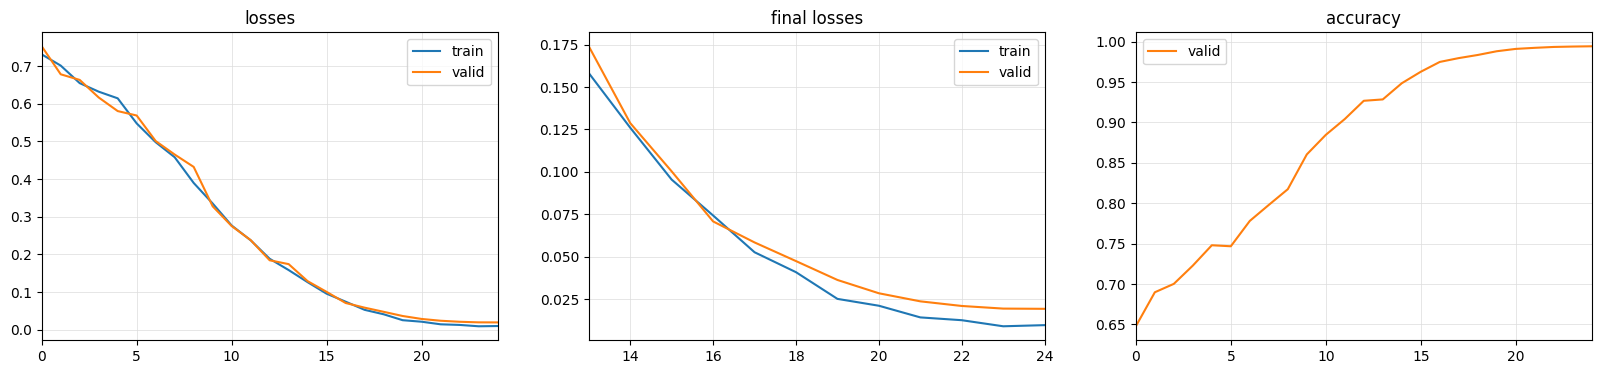

In [135]:
X=[]
y=np.empty(0)
for i in range(3):
    data=data_all['data_seg_all_'+str(i)]
    label=np.full(len(data), i)
    X.extend([p.transpose() for p in data])
    y=np.concatenate((y, label), axis=0)
X=np.array(X)
X_train, X_test, y_train, y_test = train_test_split(X, y)
X, y, splits = combine_split_data([X_train, X_test], [y_train, y_test])
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], batch_tfms=[TSStandardize()], num_workers=0)
model = InceptionTime(dls.vars, dls.c)
learn = Learner(dls, model, metrics=accuracy)
learn.fit_one_cycle(25, lr_max=1e-3)
learn.plot_metrics()
learn.save_all(path='export', dls_fname='dls', model_fname='model', learner_fname='learner')
#     display(type(X_train),X_train.shape)

In [97]:
import pickle
load_all(path='export', dls_fname='dls', model_fname='model',
           learner_fname='learner', device=None, pickle_module=pickle, verbose=True)

Learner loaded:
path          = 'export'
dls_fname     = '['dls_0.pth', 'dls_1.pth']'
model_fname   = 'model.pth'
learner_fname = 'learner.pkl'


In [ ]:
X=[]
y=np.empty(0)
for i in range(3):
    data=data_all['data_seg_all_'+str(i)]
    label=np.full(len(data), i)
    X.extend([p.transpose() for p in data])

In [ ]:
test_probas, test_targets, test_preds=learn.get_X_preds(X_test, with_decoded=True)

In [107]:
# for i in range(stock_group_num):
#     print('stock_group',i)
#     X=[]
#     y=np.empty(0)
#     for j in range(regime_num):
#         data=pd.read_csv('data_seg_'+str(i)+'_'+str(j)+'.csv').loc[:,['index', 'open', 'high', 'low', 'close', 'adjcp',
#        'pct_return', 'adjcp_filtered', 'pct_return_filtered']]
#         process_data=get_data_of_same_length(data,24)
#         label=np.full(len(process_data), j)
#         X.extend([p.transpose() for p in process_data])
#         y=np.concatenate((y, label), axis=0)
#     X=np.array(X)
#     X_train, X_test, y_train, y_test = train_test_split(X, y)
#     X, y, splits = combine_split_data([X_train, X_test], [y_train, y_test])
#     tfms  = [None, [Categorize()]]
#     dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
#     dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], batch_tfms=[TSStandardize()], num_workers=0)
#     model = InceptionTime(dls.vars, dls.c)
#     learn = Learner(dls, model, metrics=accuracy)
#     learn.fit_one_cycle(25, lr_max=1e-3)
#     learn.plot_metrics()
#     learn.save_all(path='export', dls_fname='dls_'+str(i)+'_'+str(j), model_fname='model_'+str(i)+'_'+str(j), learner_fname='learner_'+str(i)+'_'+str(j))
# #     display(type(X_train),X_train.shape)

In [26]:
import pickle

data_to_load=["data_dict_tic_APPL_generated",
               "data_dict_group_3_generated",
               "GOOG_data_generated",
              "data_all_generated"]
load_data_dict={}
for data in data_to_load:
    with open( data+'.pickle', 'rb') as handle:
        load_data_dict[data] = pickle.load(handle)

In [46]:
print(load_data_dict["GOOG_data_generated"].keys())

dict_keys(['data_seg_GOOG_0', 'data_seg_GOOG_1', 'data_seg_GOOG_2'])


In [106]:
X=[]
y=np.empty(0)
for i in range(3):
    data=data_all['data_seg_all_'+str(i)]
    label=np.full(len(data), i)
    X.extend([p.transpose() for p in data])
    y=np.concatenate((y, label), axis=0)
X=np.array(X)
print(X.shape)

(154224, 6, 24)


In [98]:
X_test=[]
X_test.extend([p.transpose() for p in load_data_dict["GOOG_data_generated"]["data_seg_GOOG_0"]])
X_test=np.array(X_test)

In [99]:
print(X_test.shape)

(673, 6, 24)


In [100]:
test_probas, test_targets, test_preds = learn.get_X_preds(X_test)

In [101]:
import json
from collections import Counter
def get_pre_res(pred_res,label):
    res = json.loads(pred_res)
    # print(res)
    res=[int(r) for r in res]
    # print(res)
    c=Counter(res)
    return c[label]/len(res)

In [136]:
def get_style_score(data_dict):
    res_dict = {}
    for k, v in data_dict.items():
        label = int(k[-1])
        X_test = []
        X_test.extend([p.transpose() for p in v])
        X_test = np.array(X_test)
        test_probas, test_targets, test_preds = learn.get_X_preds(X_test)
        # print(k,label)
        score = get_pre_res(test_preds, label)
        res_dict[k] = score
    return res_dict

In [110]:
load_data_dict.keys()

dict_keys(['data_dict_tic_APPL_generated', 'data_dict_group_3_generated', 'GOOG_data_generated', 'data_all_generated'])

In [137]:
for k in load_data_dict.keys():
    print(k,get_style_score(load_data_dict[k]))

data_dict_tic_APPL_generated {'data_seg_AAPL_0': 0.2598081952920663, 'data_seg_AAPL_1': 0.48133198789101916, 'data_seg_AAPL_2': 0.5648470770421989}


data_dict_group_3_generated {'data_seg_3_0': 0.47053502196950114, 'data_seg_3_1': 0.42910548295837264, 'data_seg_3_2': 0.4467019602232079}


GOOG_data_generated {'data_seg_GOOG_0': 0.18573551263001487, 'data_seg_GOOG_1': 0.16970458830923948, 'data_seg_GOOG_2': 0.5905820797907129}


data_all_generated {'data_seg_all_0': 0.273376986345125, 'data_seg_all_1': 0.5530971363872246, 'data_seg_all_2': 0.25379589997747243}


In [139]:
load_data_dict.keys()

dict_keys(['data_dict_tic_APPL_generated', 'data_dict_group_3_generated', 'GOOG_data_generated', 'data_all_generated'])

In [141]:
load_data_dict['data_dict_tic_APPL_generated'].keys()

dict_keys(['data_seg_AAPL_0', 'data_seg_AAPL_1', 'data_seg_AAPL_2'])

In [142]:
load_data_dict['data_dict_tic_APPL_generated']['data_seg_AAPL_0'].shape

(1147, 24, 6)

In [138]:
from random import sample

In [221]:
from sklearn.linear_model import LinearRegression
def calculate_slope(data,plot=False,num=3,name=''):
    try:
        number_of_sample=data.shape[0]
    except: 
        number_of_sample=len(data)
    sample_list=sample([i for i in range(number_of_sample)],num*num)
    if plot:
        fig, ax = plt.subplots(num,num)
        for i, s in enumerate(sample_list):
            data_s=data[s]
            # print(data_s.shape)
            data_s_adjcp=data_s[:,4].flatten()
            ax[i//num][i%num].plot(data_s_adjcp)
        plt.show()
        fig.savefig('./fig/'+str(name)+'.png')
    slope_list=[]
    for i in range(number_of_sample):
        data_s=data[i]
        # print(data_s.shape)
        data_s_adjcp=data_s[:,4].reshape(-1, 1)
        if data_s_adjcp[0]==0:
            continue
        x=np.asarray([i for i in range(len(data_s_adjcp))]).reshape(-1, 1)
        reg=LinearRegression().fit(x, data_s_adjcp)
        slope=(100*reg.coef_/data_s_adjcp[0])[0][0]
        # print(slope)
        slope_list.append(slope)
    print(pd.DataFrame(slope_list).describe())
def get_slope_of_dict(data_dict,plot=False,num=3,prefix=''):
    for k,v in data_dict.items():
        regime=int(k[-1])
        print(k)
        calculate_slope(v,plot,num,prefix+str(k))

In [200]:
GOOG_data.keys()

dict_keys(['data_seg_GOOG_0', 'data_seg_GOOG_1', 'data_seg_GOOG_2'])

data_seg_all_0


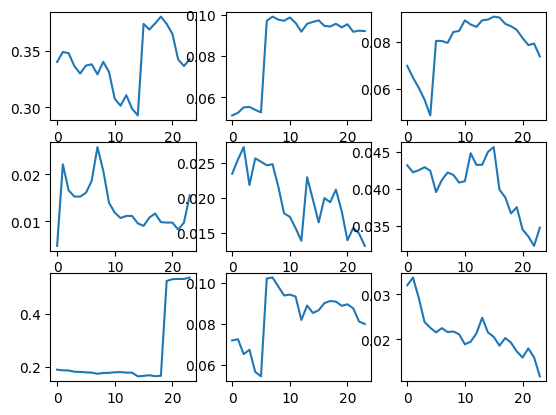

                  0
count  25040.000000
mean       1.258027
std        9.501309
min      -39.174045
25%       -0.752512
50%       -0.221264
75%        0.926265
max      552.962281
data_seg_all_1


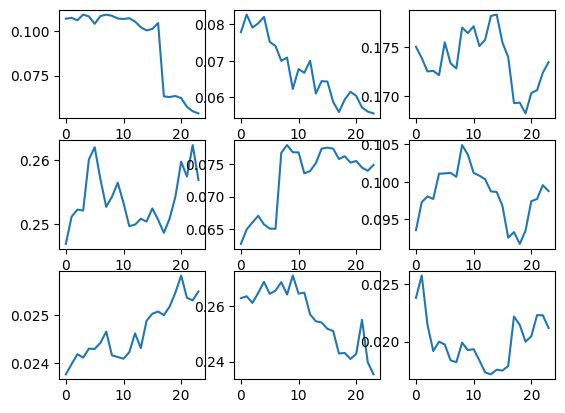

                  0
count  84782.000000
mean       0.223271
std        2.091799
min       -8.275311
25%       -0.197685
50%        0.071905
75%        0.363274
max      272.136582
data_seg_all_2


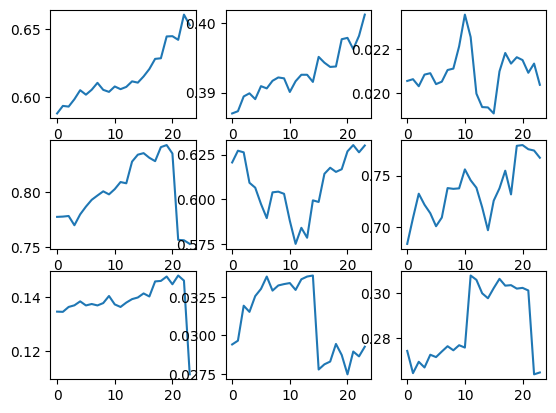

                  0
count  44375.000000
mean       0.615261
std       20.048745
min       -7.775195
25%       -0.027997
50%        0.383316
75%        0.761905
max     3873.202323


In [224]:
get_slope_of_dict(data_all,True,3,'ori_')

data_seg_all_0


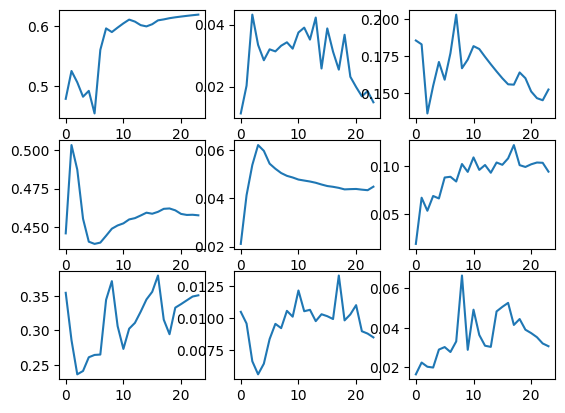

                  0
count  25046.000000
mean       0.607973
std        3.188507
min       -8.846053
25%       -0.928046
50%       -0.039404
75%        1.218403
max       62.521399
data_seg_all_1


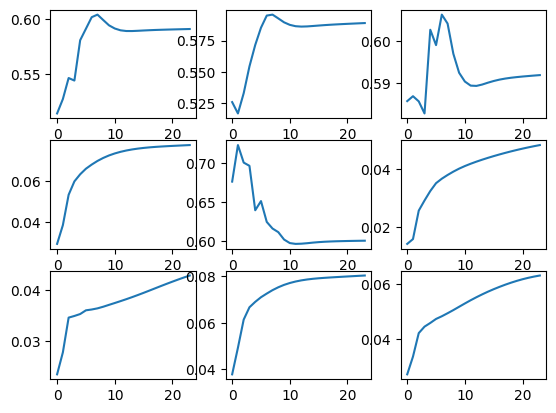

                  0
count  84788.000000
mean       2.594425
std        3.357904
min       -1.279808
25%        0.159974
50%        1.218785
75%        4.222692
max       12.284522
data_seg_all_2


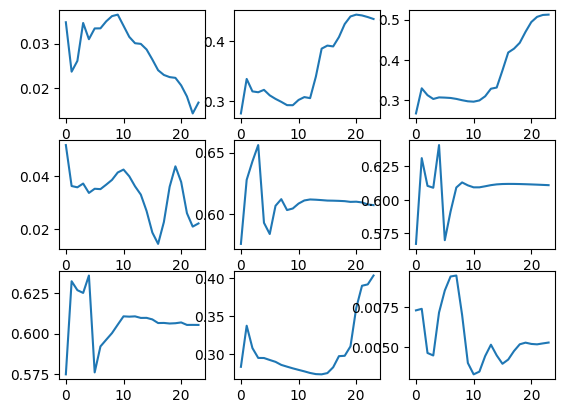

                  0
count  44390.000000
mean       0.110134
std        2.253796
min       -6.415559
25%       -0.829491
50%       -0.058433
75%        0.358458
max       48.158939


In [225]:
get_slope_of_dict(load_data_dict['data_all_generated'],True,3,'generated_')

data_seg_GOOG_0


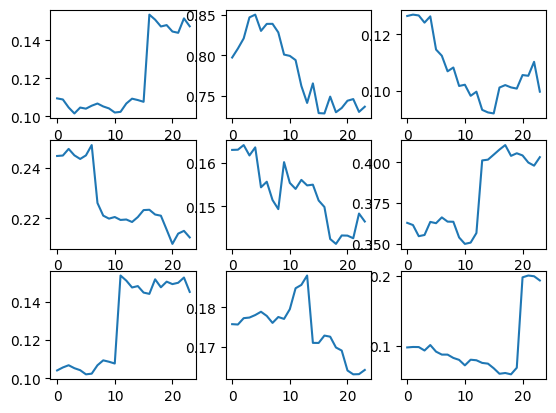

                0
count  673.000000
mean     0.835465
std      2.766863
min     -3.077239
25%     -0.555483
50%      0.064380
75%      1.023569
max     18.327444
data_seg_GOOG_1


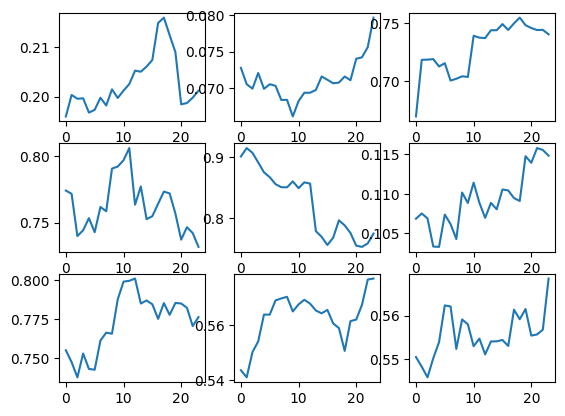

                 0
count  1591.000000
mean      0.319558
std       1.157543
min      -3.506264
25%      -0.139346
50%       0.091979
75%       0.396395
max      11.302775
data_seg_GOOG_2


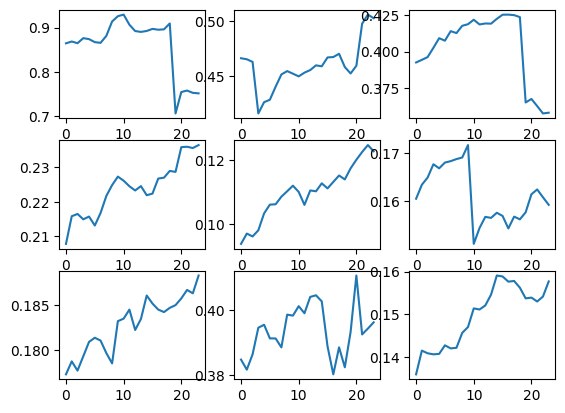

                 0
count  1528.000000
mean      1.407132
std      18.960241
min      -4.055966
25%       0.093051
50%       0.354006
75%       0.679426
max     686.756314


In [222]:
get_slope_of_dict(GOOG_data,True,3,'ori_')

data_seg_GOOG_0


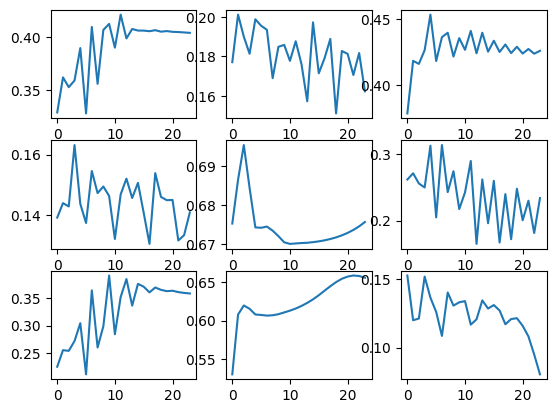

                0
count  673.000000
mean     0.635476
std      2.058644
min     -1.298161
25%     -0.322674
50%      0.018500
75%      0.724340
max     12.193933
data_seg_GOOG_1


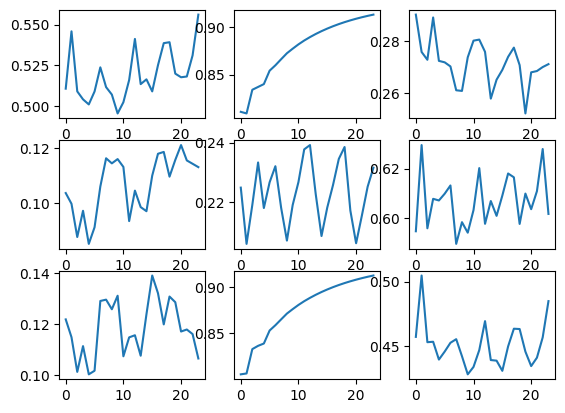

                 0
count  1591.000000
mean      0.310074
std       0.789752
min      -0.717483
25%      -0.113804
50%       0.063536
75%       0.453427
max       4.275691
data_seg_GOOG_2


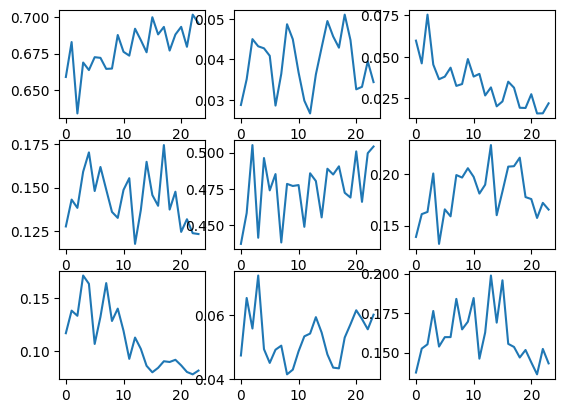

                 0
count  1529.000000
mean     -0.365016
std       1.115086
min      -3.330602
25%      -1.008452
50%       0.083583
75%       0.272979
max       6.032181


In [223]:
get_slope_of_dict(load_data_dict['GOOG_data_generated'],True,3,'generated_')

In [ ]:
get_slope_of_dict(load_data_dict['data_all_generated'])

# Key takeaway

InceptionTime can do the job

In [50]:
X, y, splits = get_classification_data('LSST', split_data=False)

In [53]:
tfms  = [None, TSClassification()] # TSClassification == Categorize
batch_tfms = TSStandardize()
dls = get_ts_dls(X, new_y, splits=splits, tfms=tfms, batch_tfms=batch_tfms, bs=[64, 128])
dls.dataset

NameError: name 'new_y' is not defined

In [47]:
def get_std_list(data):
    intervals=get_intervals(data)
    std_list=[]
    data.drop(columns=['index'])
    for interval in intervals:
        data_seg=data.iloc[interval[0]:interval[1],:].to_numpy()
        std=data_seg.adj.std()
        std_list.append(std)
    return std_list

In [ ]:
batch_tfms = TSStandardize(by_sample=True)
mv_clf = TSClassifier(X, y, splits=splits, path='models', arch=InceptionTimePlus, batch_tfms=batch_tfms, metrics=accuracy, cbs=ShowGraph())
mv_clf.fit_one_cycle(10, 1e-2)
mv_clf.export("mv_clf.pkl")

## inference

## inference